# 1. DATA COLLECTION

## 1.1. Topic

- Bộ dữ liệu ghi nhận các sự cố giữa cá mập và con người tại Úc, bao gồm các vụ tấn công, va chạm hoặc cố gắng cắn.

- Chủ đề thuộc lĩnh vực sinh thái biển và an toàn con người, phản ánh bối cảnh thực tế ngoài đời sống, giúp nghiên cứu hành vi cá mập, mức độ nguy hiểm, yếu tố môi trường và rủi ro đối với con người khi tham gia các hoạt động dưới nước. 

## 1.2. Data source

- Bộ dữ liệu: [Australian Shark-Incident Database (ASID)](https://taronga.org.au/conservation-and-science/australian-shark-incident-database)

- Tổ chức quản lý và thu thập: Taronga Conservation Society Australia, phối hợp với Flinders University và NSW Department of Primary Industries.

- Thời gian thu thập kéo dài từ 1791 đến hiện tại, được cập nhật theo từng năm.

## 1.3. Dataset license

- Bộ dữ liệu được chia sẻ công khai theo giấy phép mở thông qua GitHub của ASID ([GitHub – AustralianSharkIncidentDatabase](https://github.com/cjabradshaw/AustralianSharkIncidentDatabase)).

- Người sử dụng được phép dùng cho mục đích học thuật, nghiên cứu và các phân tích khoa học.

- Khi sử dụng hoặc trích dẫn cần ghi rõ nguồn gốc: "Australian Shark-Incident Database, Taronga Conservation Society Australia"

- Không có giới hạn thương mại cụ thể nhưng phải đảm bảo giữ nguyên tính toàn vẹn nội dung và ghi nhận nguồn theo quy định.

## 1.4. Collection method

- Dữ liệu được tổng hợp từ nhiều nguồn:

    - báo cáo của nhân chứng/nạn nhân

    - báo chí, truyền thông

    - báo cáo chính thức từ cơ quan thủy sản, cảnh sát, y tế

    - hồ sơ điều tra thực địa

- Sau khi tiếp nhận thông tin, Taronga tiến hành xác minh bằng khảo sát, phỏng vấn, báo cáo y tế và điều tra độc lập.

- Đối tượng khảo sát: các vụ việc có con người tham gia hoạt động dưới nước hoặc phương tiện nhỏ (surfboard, kayak, lặn…).

- Các vụ việc chỉ được đưa vào database nếu đáp ứng 3 tiêu chí: 
    - (i) người còn sống tại thời điểm xảy ra vụ.
    - (ii) người đang ở trong nước hoặc sử dụng phương tiện nhỏ như kayak, surfboard...
    - (iii) có biểu hiện rõ ràng của cá mập cắn người, thiết bị hoặc phương tiện nhỏ. Có thể ghi lại dù vết cắn không thành công (bumped, attempted bite). 

- Thời gian thu thập: hơn 230 năm dữ liệu lịch sử (từ 1791 đến nay).

- Hạn chế tiềm ẩn:

    - dữ liệu trước thế kỷ 20 có thể thiếu chính xác do báo cáo không đầy đủ

    - có thể tồn tại bias từ báo chí hoặc nhân chứng

    - không phải vụ việc nào cũng xác định được loài cá mập

## 1.5. Choice rationale

- Chủ đề mới lạ, mang tính thực tiễn, gần gũi với vấn đề an toàn con người trong tự nhiên.

- Dữ liệu có nhiều biến phong phú, cho phép khai thác nhiều hướng phân tích.

- Thông tin cung cấp có nhiều khía cạnh cần xử lí, phù hợp với tính chất môn học và đồ án.

- Bộ dữ liệu phù hợp với mục tiêu nghiên cứu khoa học dữ liệu của nhóm, có thể đưa ra nhận định, trực quan hóa và khám phá kiến thức mới.

# 2. DATA EXPLORATION

## 2.1. Dataset overview

In [213]:
# Import thư viện, load dữ liệu và chuẩn hóa tên cột

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập hiển thị 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Hàm chuẩn hóa tên cột: bỏ ký tự đặc biệt, khoảng trắng, đổi sang lowercase
def clean_col_name(c):
    c = c.strip()
    c = c.replace(" ", "_").replace(".", "_").replace("/", "_")
    c = c.replace("(", "").replace(")", "").replace("<", "lt_").replace(">", "gt_")
    while "__" in c:
        c = c.replace("__", "_")
    return c.lower().strip("_")

data_path = "data/raw/SharkIncident.csv"
df = pd.read_csv(data_path, low_memory=False)

# Số dòng và cột
print("Số dòng:", df.shape[0])
print("Số cột:", df.shape[1])

# Chuẩn hóa tên các cột
df.columns = [clean_col_name(c) for c in df.columns]

print("5 dòng đầu:")
display(df.head())

Số dòng: 1283
Số cột: 60
5 dòng đầu:


,uin,incident_month,incident_year,victim_injury,state,location,latitude,longitude,site_category,site_category_comment,shark_common_name,shark_scientific_name,shark_identification_method,shark_identification_source,shark_length_m,basis_for_length,provoked_unprovoked,provocative_act,no_sharks,victim_activity,fish_speared?,commercial_dive_activity,object_of_bite,present_at_time_of_bite,direction_first_strike,shark_behaviour,victim_aware_of_shark,shark_captured,injury_location,injury_severity,victim_gender,victim_age,victim_clothing,clothing_coverage,dominant_clothing_colour,other_clothing_colour,clothing_pattern,fin_colour,diversionary_action_taken,diversionary_action_outcome,people_lt_3m,people_3-15m,time_of_incident,depth_of_incident_m,teeth_recovered,time_in_water_min,water_temperature_°c,total_water_depth_m,water_visability_m,distance_to_shore_m,spring_or_neap_tide,tidal_cycle,wind_condition,weather_condition,air_temperature_°c,personal_protective_device,deterrent_brand_and_type,data_source,reference,unnamed:_59
0,1,1,1791,fatal,NSW,sydney (near),-33.86,151.2000,coastal,NaN,white shark,Carcharodon carcharias,"bite analysis, shark behaviour, geographical location",NaN,NaN,NaN,unprovoked,NaN,NaN,swimming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,torso,major lacerations,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,book,"shark&survl, whitley 1958, book ref 1793",NaN
1,2,3,1803,injured,WA,"shark bay, faure island",-25.8826,113.9226,coastal,bay to open ocean,tiger shark,Galeocerdo cuvier,"bite analysis, shark behaviour, geographical location",NaN,NaN,NaN,unprovoked,NaN,1.0,swimming,NaN,NaN,NaN,NaN,NaN,swam at victim,Y,NaN,NaN,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pushed at shark,NaN,NaN,NaN,NaN,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,book,"balgridge,green,taylor,whitley 1940",NaN
2,3,1,1807,injured,NSW,"sydney harbour, cockle bay",-33.8661,151.2010,estuary/harbour,bay,bull shark,Carcharhinus leucas,"bite analysis, shark behaviour",NaN,NaN,NaN,unprovoked,NaN,1.0,swimming,NaN,NaN,NaN,NaN,NaN,bit victim on wrist,NaN,NaN,"arm, hand",minor lacerations,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,media outlet,sydney gazette 18.1.1807,NaN
3,4,1,1820,fatal,TAS,"sweetwater point, pitt water",-42.8025,147.4868,estuary/harbour,bay to open ocean,NaN,NaN,NaN,NaN,NaN,NaN,provoked,NaN,1.0,swimming,NaN,NaN,NaN,catch,NaN,bit victim on leg,N,NaN,leg,major lacerations,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,witness account,"shark&survl, c. black researcher",NaN
4,5,1,1825,injured,NSW,"sydney harbour, kirribili point",-33.8527,151.2188,estuary/harbour,harbour,bull shark,Carcharhinus leucas,"bite analysis, shark behaviour, geographical location",NaN,NaN,NaN,unprovoked,NaN,1.0,swimming,NaN,NaN,NaN,NaN,NaN,bit legs,NaN,NaN,leg,minor lacerations,male,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,media outlet,maitland daily mercury 13.11.1899,NaN


### 2.1.1. Basic information
- Dữ liệu gốc gồm: 1283 dòng và 60 cột.

- Mỗi dòng tương ứng một vụ việc — gồm thông tin về thời gian (tháng, năm), vị trí (latitude, longitude, bang/tiểu bang, địa điểm cụ thể), tình trạng nạn nhân (thương tích, tử vong, không bị thương), loài cá mập nếu biết, hoạt động của nạn nhân lúc xảy ra vụ việc, và nhiều biến khác liên quan: điều kiện nước, thời tiết, hoạt động lặn/câu cá, sự kiện kích động (provoked / unprovoked), thông tin về thiết bị bảo hộ, v.v.

- Dữ liệu ban đầu được lưu dưới dạng .xlsl, được chuyển về .csv và có tổng kích thước 436KB.

### 2.1.2. Data integrity

In [214]:
# Kiểm tra duplicated rows
dups = df.duplicated()
print(f"\nSố dòng trùng lặp: {dups.sum()}")


Số dòng trùng lặp: 0


In [215]:
empty_rows = df.isnull().all(axis=1).sum()
print(f"Số dòng hoàn toàn trống: {empty_rows}")

Số dòng hoàn toàn trống: 0


In [216]:
print("Số ID trùng lặp:", df['uin'].duplicated().sum())

Số ID trùng lặp: 0


### 2.1.3. Column inventory

| Tên cột                                                                 | Ý nghĩa                                                                         |
| ------------------------------------------------------------------------ | ------------------------------------------------------------------------------- |
| **uin**                                                                  | Mã định danh duy nhất cho mỗi vụ việc.                 |
| **incident_month**                                                       | Tháng xảy ra vụ việc.                              |
| **incident_year**                                                        | Năm xảy ra vụ việc(yyyy).                                                               |
| **victim_injury**                                                        | Loại thương tích (fatal / injured / uninjured)                                 |
| **state**                                                                | Bang/khu vực địa lý nơi vụ việc xảy ra.                                         |
| **location**                                                             | Địa điểm cụ thể hơn của sự cố (bãi biển, vùng biển…).                           |
| **latitude**, **longitude**                                              | Toạ độ địa lý của vụ tấn công.                                                  |
| **site_category**, **site_category_comment**                             | Loại địa điểm (bơi, lặn, câu cá…) + ghi chú bổ sung.                            |
| **shark_common_name**                                                    | Tên thông thường của loài cá mập liên quan tới sự cố.                             |
| **shark_scientific_name**                                                | Tên khoa học của loài cá mập liên quan tới sự cố.                                              |
| **shark_identification_method**                                          | Phương pháp xác định loài (DNA, răng, vết cắn, hành vi…).                          |
| **shark_identification_source**                                          | Nguồn xác nhận thông tin loài (báo cáo, nhân chứng…).                           |
| **shark_length_m**                                                       | Chiều dài ước tính của cá mập (m).                                              |
| **basis_for_length**                                                     | Cơ sở để ước lượng chiều dài (quan sát, đo đạc, camera…).                       |
| **provoked_unprovoked**                                                  | Vụ tấn công mang tính tự nhiên hay bị kích động (unprovoked / provoked).        |
| **provocative_act**                                                      | Hành động cụ thể gây kích động (nếu có).                                        |
| **no_sharks**                                                            | Số lượng cá mập xuất hiện.                                  |
| **victim_activity**                                                      | Nạn nhân đang làm gì tại thời điểm bị tấn công (bơi, lướt ván…).                |
| **fish_speared?**                                                        | Cá mập có bị tấn công/thương tích hay không. |
| **commercial_dive_activity**                                             | Hoạt động lặn có mang tính thương mại/tour hay cá nhân.                         |
| **object_of_bite**                                                       | Bộ phận bị cá mập cắn: người, ván lướt, thuyền…                                 |
| **present_at_time_of_bite**                                              | Những gì xuất hiện cạnh nạn nhân (đàn cá, chim biển…).                          |
| **direction_first_strike**                                               | Hướng tiếp cận ban đầu của cá mập.                                              |
| **shark_behaviour**                                                      | Hành vi quan sát được (rình rập, bơi vòng…).                                    |
| **victim_aware_of_shark**                                                | Nạn nhân có phát hiện cá mập trước khi bị cắn hay không.                        |
| **shark_captured**                                                       | Cá mập có bị bắt lại sau sự cố hay không.                                       |
| **injury_location**                                                      | Vị trí thương tích trên cơ thể.                                                 |
| **injury_severity**                                                      | Mức độ thương tích (nhẹ, trung bình, nghiêm trọng, tử vong…).                   |
| **victim_gender**, **victim_age**                                        | Giới tính và độ tuổi nạn nhân.                                                   |
| **victim_clothing**, **clothing_coverage**, **dominant_clothing_colour** | Thông tin trang phục.          |
| **other_clothing_colour**, **clothing_pattern**                          | Màu sắc/phối hoa văn phụ của trang phục.                                   |
| **fin_colour**                                                           | Màu vây/flippers của nạn nhân(>=2 màu = multicolour).                                                   |
| **diversionary_action_taken**                                            | Nạn nhân/xung quanh có hành động xua đuổi không.                                |
| **diversionary_action_outcome**                                          | Kết quả hành động xua đuổi đó.                                                           |
| **people_lt_3m**, **people_3-15m**                                       | Số người có mặt gần nạn nhân trong bán kính 3m hoặc 3–15m.                      |
| **time_of_incident**                                                     | Thời điểm xảy ra sự cố (định dạng ví dụ: 1830).                               |
| **depth_of_incident_m**, **total_water_depth_m**                         | Độ sâu nơi xảy ra sự cố và độ sâu tổng khu vực.                                  |
| **teeth_recovered**                                                      | Có thu hồi được răng/mảnh răng nào không.                 |
| **time_in_water_min**                                                    | Thời gian nạn nhân đã ở dưới nước trước vụ việc (phút).                                |
| **water_temperature_°c**, **air_temperature_°c**                         | Nhiệt độ nước và nhiệt độ không khí.                                            |
| **water_visability_m**                                                   | Tầm nhìn dưới nước (m).                                                         |
| **distance_to_shore_m**                                                  | Khoảng cách từ vị trí bị tấn công tới bờ.                                       |
| **spring_or_neap_tide**, **tidal_cycle**                                 | Trạng thái thuỷ triều.                        |
| **wind_condition**, **weather_condition**                                | Điều kiện gió và thời tiết.                                 |
| **personal_protective_device**                                           | Nạn nhân có mặc đồ bảo hộ hay không.                                         |
| **deterrent_brand_and_type**                                             | Loại thiết bị chống cá mập được sử dụng.                                        |
| **data_source**, **reference**                                           | Nguồn gốc dữ liệu, tài liệu tham khảo.                                          |
| **unnamed:_59**                                                          | Cột rác.                                            |


In [217]:
# Các cột cần loại bỏ
cols_to_drop = [
    "uin",                   # Mã định danh duy nhất (không có giá trị phân tích)
    "data_source",           # Nguồn ghi nhận (quá chi tiết/không ảnh hưởng đến sự cố)
    "reference",             # Tài liệu tham khảo (không có giá trị phân tích)

    # Cột trùng lặp/Thông tin chi tiết quá mức
    "shark_scientific_name", # Tên khoa học (trùng lặp ý nghĩa với shark_common_name)
    "site_category_comment", # Ghi chú bổ sung 
    "provocative_act",       # Hành động kích động cụ thể (quá chi tiết/thường missing)
    "victim_clothing",       # Thông tin quần áo (vì đã có cột màu và hoa văn)
    "clothing_coverage",     # Độ che phủ quần áo (quá chi tiết, thường missing)
    "other_clothing_colour", # Màu phụ của quần áo
    "shark_identification_source", # Nguồn xác nhận loài (quá chi tiết, không ảnh hưởng đến phân tích)

    # Xóa cột tọa độ vì đã có cột location
    "latitude",    
    "longitude"         
]

df = df.drop(columns=cols_to_drop)

print(f"Đã loại bỏ {len(cols_to_drop)} cột.")
print("Các cột bị loại bỏ:")
print(cols_to_drop)
print(f"Kích thước data sau khi loại bỏ: {df.shape}")

Đã loại bỏ 12 cột.
Các cột bị loại bỏ:
['uin', 'data_source', 'reference', 'shark_scientific_name', 'site_category_comment', 'provocative_act', 'victim_clothing', 'clothing_coverage', 'other_clothing_colour', 'shark_identification_source', 'latitude', 'longitude']
Kích thước data sau khi loại bỏ: (1283, 48)


### 2.1.4. Data types

In [218]:
# in các cột và kiểu dữ liệu ra
col_info = pd.DataFrame({
    "dtype": df.dtypes
})
display(col_info)

,dtype
incident_month,int64
incident_year,int64
victim_injury,object
state,object
location,object
site_category,object
shark_common_name,object
shark_identification_method,object
shark_length_m,object
basis_for_length,object


Kiểu dữ liệu của các biến `latitude, shark_length_m, victim_age, time_of_incident, time_in_water_min, depth_of_incident_m, total_water_depth_m` hiện đang là object thay vì number, vì vậy cần chuyển đổi về dạng số trước khi đưa vào phân tích.

In [219]:
# Các cột object cần chuyển sang dạng số
to_convert_cols = [
    "shark_length_m", "victim_age",
    "time_of_incident", "time_in_water_min",
    "depth_of_incident_m", "total_water_depth_m"
]

for col in to_convert_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)      # đổi dấu phẩy thành dấu chấm
        .str.extract(r"([-+]?[0-9]*\.?[0-9]+)")  # tách giá trị số 
        .astype(float)                                          
    )

## 2.2. Missing value analysis


Bảng tổng hợp missing values:

                             missing_count  missing_percent
spring_or_neap_tide                   1283           100.00
unnamed:_59                           1282            99.92
fish_speared?                         1279            99.69
deterrent_brand_and_type              1277            99.53
clothing_pattern                      1271            99.06
fin_colour                            1251            97.51
tidal_cycle                           1249            97.35
air_temperature_°c                    1240            96.65
personal_protective_device            1227            95.64
weather_condition                     1226            95.56
teeth_recovered                       1223            95.32
diversionary_action_outcome           1217            94.86
water_visability_m                    1211            94.39
wind_condition                        1202            93.69
people_3-15m                          1198            93.37
water_te

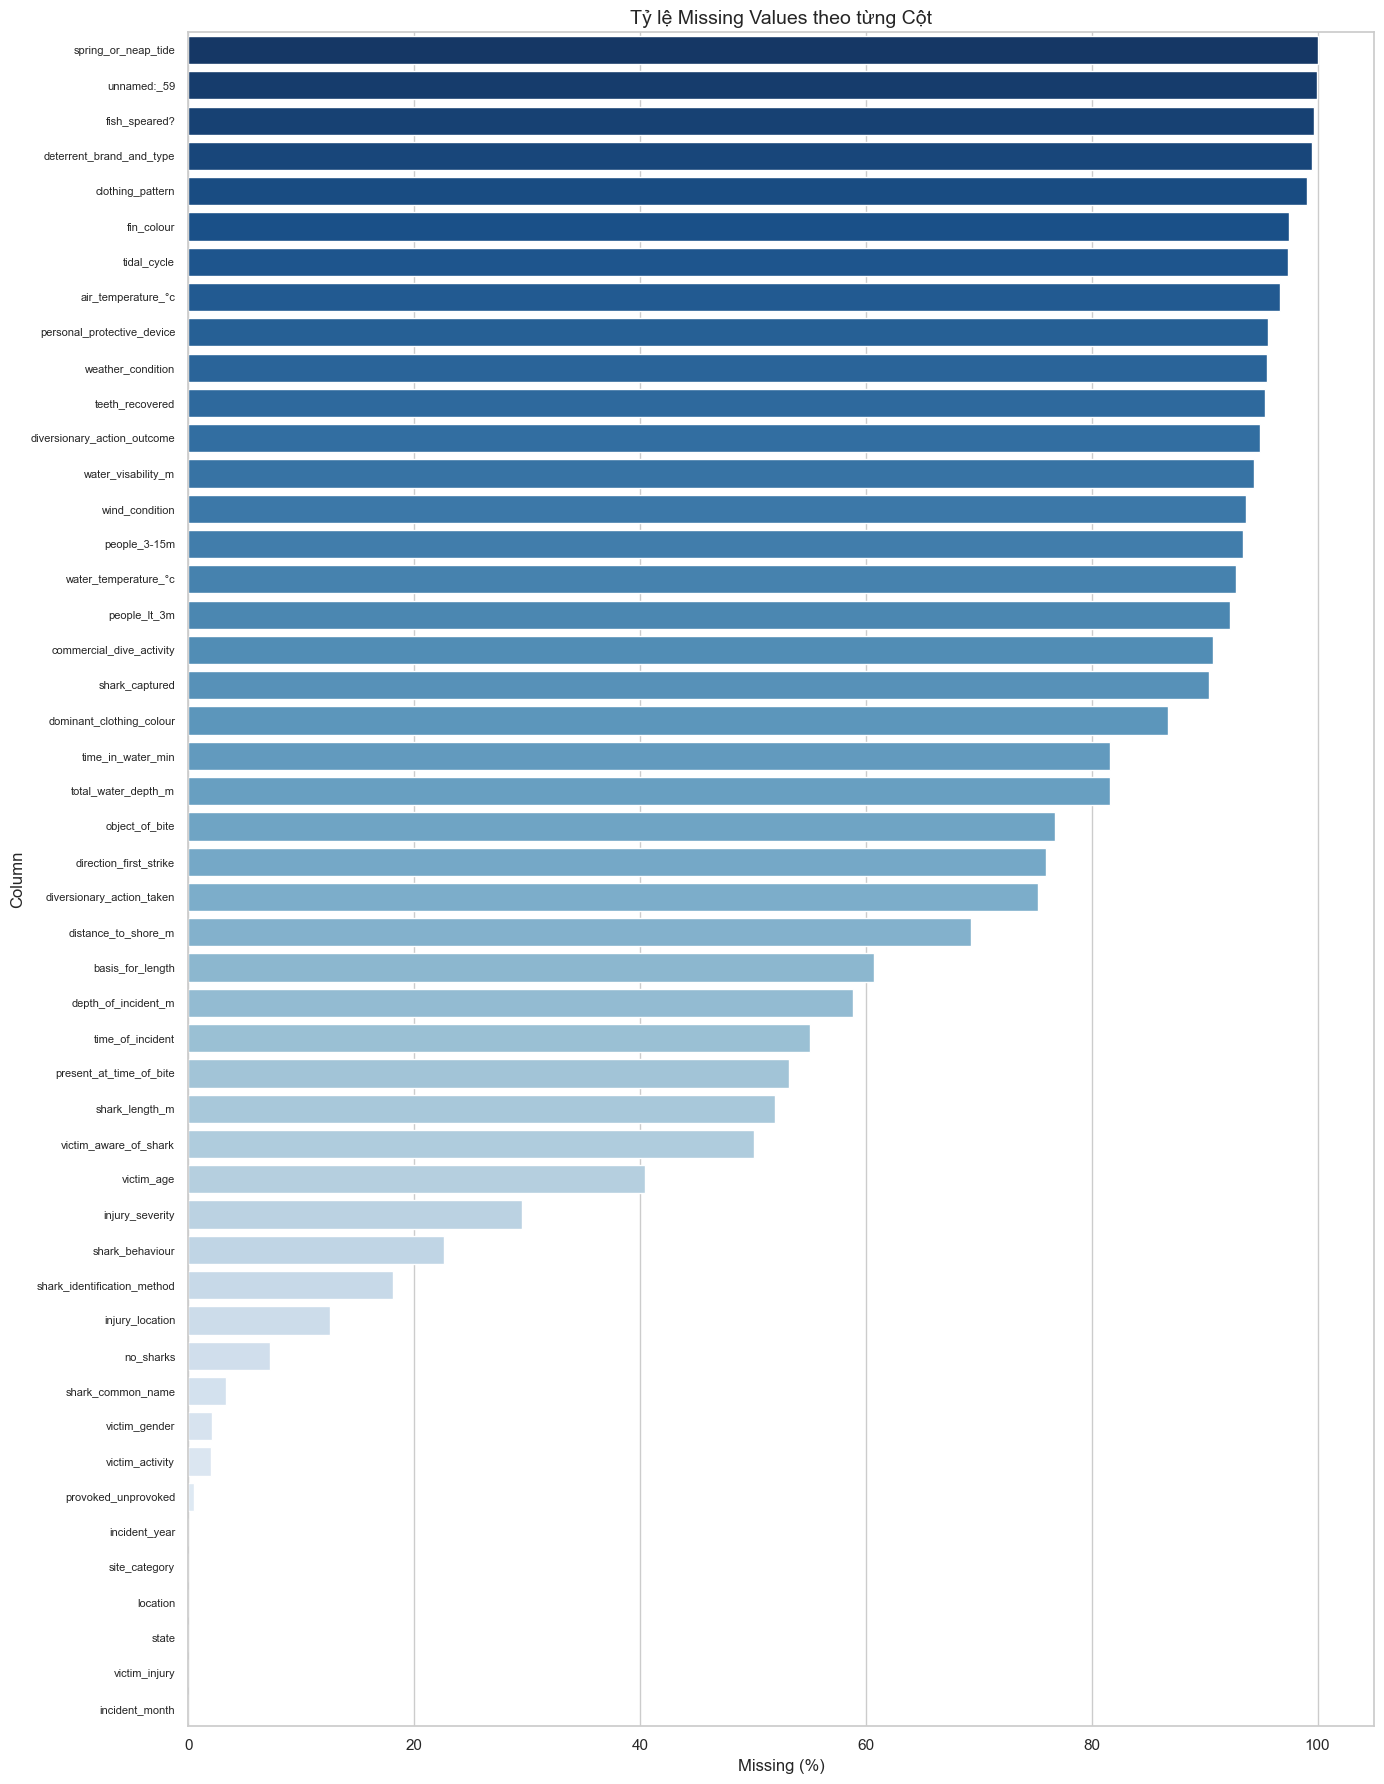

In [220]:
# Thống kê missing value

missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": (df.isna().mean()*100).round(2)
}).sort_values(by="missing_percent", ascending=False)

print("\nBảng tổng hợp missing values:\n")
print(missing_summary)

print("\nBar Chart Missing Values theo từng cột:")
plt.figure(figsize=(14,18)) 
sns.barplot(
    data=missing_summary.reset_index(),
    x="missing_percent", y="index", palette="Blues_r"
)
plt.xlabel("Missing (%)", fontsize=12)
plt.ylabel("Column", fontsize=12)
plt.yticks(fontsize=8)       
plt.title("Tỷ lệ Missing Values theo từng Cột", fontsize=14)
plt.tight_layout()
plt.show()

Giá trị thiếu trong bộ dữ liệu này chủ yếu phát sinh từ tính chất lịch sử, rời rạc của quá trình thu thập và khó khăn trong việc quan sát tại hiện trường.
Các cột thiếu nhiều thường thuộc loại text mô tả chi tiết, khó đo lường hoặc phân nhóm

In [221]:
# Các cột cần loại bỏ
cols_to_drop = [
    # Cột có quá nhiều giá trị missing (>99%)
    'fish_speared?',         
    'clothing_pattern',      
    'spring_or_neap_tide',  
    'deterrent_brand_and_type', 
    'unnamed:_59',               
]

df = df.drop(columns=cols_to_drop)

print(f"Đã loại bỏ {len(cols_to_drop)} cột.")
print("Các cột bị loại bỏ:")
print(cols_to_drop)
print(f"Kích thước data sau khi loại bỏ: {df.shape}")

Đã loại bỏ 5 cột.
Các cột bị loại bỏ:
['fish_speared?', 'clothing_pattern', 'spring_or_neap_tide', 'deterrent_brand_and_type', 'unnamed:_59']
Kích thước data sau khi loại bỏ: (1283, 43)


#### Vì sao chọn loại bỏ các cột có >99% missing thay vì xóa dòng?

- Các cột thiếu quá 99% dữ liệu không còn đủ thông tin để phân tích hay huấn luyện mô hình. Giữ lại chỉ làm tăng nhiễu và độ phức tạp.

- Nếu cố gắng giữ lại các cột này, ta gần như phải điền toàn bộ giá trị, khiến biến trở nên kém ý nghĩa và dễ gây sai lệch.

- Việc drop cột giúp giữ lại tối đa số dòng, nếu drop dòng thay vì drop cột thì sẽ làm mất dữ liệu quan sát.


In [222]:
# Xử lí missing values
num_cols = df.select_dtypes(include=['number']).columns.tolist()
invalid_numeric_cols = [
    c for c in num_cols
    if any(k in c.lower() for k in ["length", "age", "distance", 
                                       "total_water_depth", "visability", "people"])
]

# Chuyển âm thành NaN, 0 thành NaN (trừ depth_of_incident_m vì 0 được xem là trên mặt nước)
for c in invalid_numeric_cols:
    # Chuyển giá trị âm (< 0) thành NaN
    df.loc[df[c] < 0, c] = np.nan
    
    # Ngoại trừ 'depth_of_incident_m'
    if c.lower() != "depth_of_incident_m":
        df.loc[df[c] == 0, c] = np.nan

# Điền -1 cho tất cả các cột số
df[num_cols] = df[num_cols].fillna(-1)

# Điền 'unknown' cho tất cả các cột phân loại
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
df[cat_cols] = df[cat_cols].fillna("unknown")

#### Vì sao chọn cách thay giá trị này?

- Chọn thay missing value và các giá trị sai (âm hoặc bằng 0) của các cột số thành –1 và thay missing value của các cột phân loại thành “unknown” vì đây là dữ liệu ghi nhận thực tế. Nếu điền median hoặc mode sẽ tạo ra giá trị không có cơ sở và làm sai lệch dữ liệu gốc.

- Riêng cột depth_of_incident_m vẫn giữ giá trị 0 vì theo ngữ cảnh dữ liệu, 0 được xem là sự cố xảy ra ngay trên mặt nước hoặc sát bờ biển.

## 2.3. Numerical columns analysis

,mean,std,min,median,max
incident_month,5.915822,4.058937,1.0,5.00,12.0
incident_year,1970.664069,48.680308,1791.0,1989.00,2025.0
shark_length_m,2.682296,1.199854,0.3,2.60,6.0
no_sharks,1.032773,0.335359,1.0,1.00,10.0
victim_age,28.604194,14.253446,4.0,25.00,84.0
people_lt_3m,1.655914,1.542828,1.0,1.00,12.0
people_3-15m,3.273810,5.477998,1.0,2.00,40.0
time_of_incident,1278.057192,410.040299,130.0,1300.00,2330.0
depth_of_incident_m,2.193939,5.510993,0.0,0.00,45.0
time_in_water_min,59.725000,250.521424,0.1,10.00,2160.0


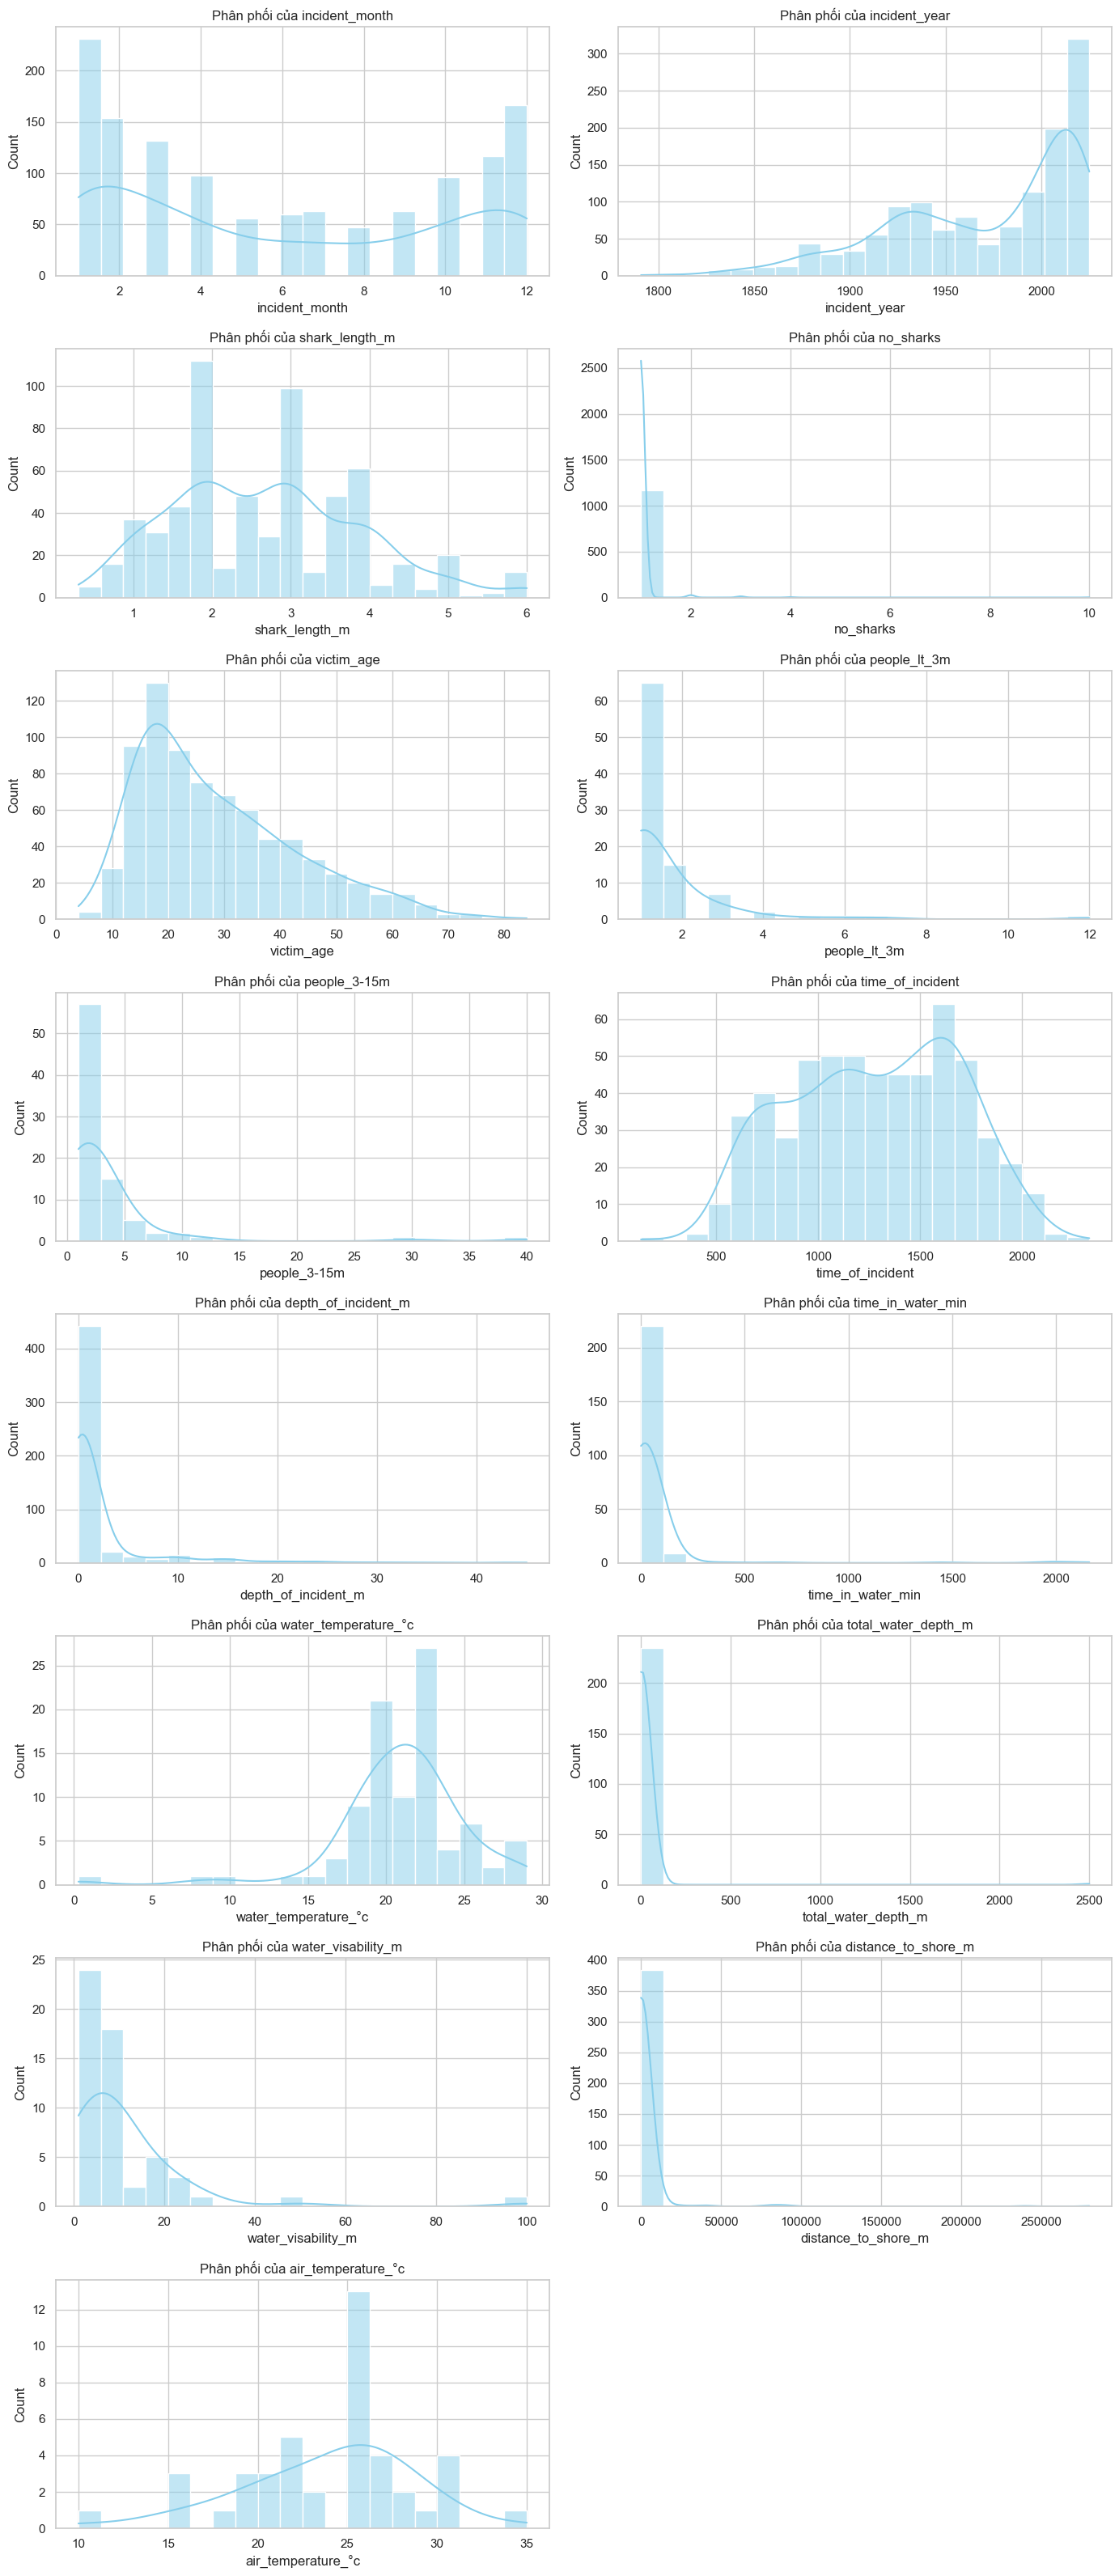

In [223]:
# Thống kê mô tả
stats_num_df = df[num_cols].replace(-1, np.nan).describe().transpose()
stats_num_df = stats_num_df[['mean','std','min','50%','max']]
stats_num_df.rename(columns={'50%':'median'}, inplace=True)
display(stats_num_df)

# Trực quan hóa 2 hình trên 1 dòng
n_cols = 2
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # ceil(len/2)
plt.figure(figsize=(14, n_rows * 4))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    data_valid = df[col][df[col] != -1].dropna()
    if data_valid.empty:
        plt.title(f'Không có dữ liệu hợp lệ cho {col}')
        continue
    sns.histplot(data_valid, kde=True, bins=20, color='skyblue')
    plt.title(f'Phân phối của {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [224]:
# Phân tích outlier

def detect_outliers(series):
    s = series[series != -1]  # bỏ -1 ra khỏi dữ liệu (các tường hợp missing được xử lí)
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    out = s[(s < lower) | (s > upper)]
    return (len(out), len(out)/len(s)*100, s.min(), s.max(), lower, upper)

result = []
for col in df.select_dtypes(include=np.number).columns:
    count, rate, minv, maxv, low, up = detect_outliers(df[col])
    result.append([col, count, rate, minv, maxv, low, up])

outlier_df = pd.DataFrame(result, columns=[
    " Cột ", " Số lượng outlier ", " Tỷ lệ % ", 
    " Min ", " Max ", " Ngưỡng dưới ", " Ngưỡng trên "
])

print("Thống kê outlier:")
display(outlier_df)

Thống kê outlier:


,Cột,Số lượng outlier,Tỷ lệ %,Min,Max,Ngưỡng dưới,Ngưỡng trên
0,incident_month,0,0.000000,1.0,12.0,-10.000,22.000
1,incident_year,3,0.233827,1791.0,2025.0,1815.500,2131.500
2,shark_length_m,0,0.000000,0.3,6.0,-0.750,6.050
3,no_sharks,21,1.764706,1.0,10.0,1.000,1.000
4,victim_age,8,1.048493,4.0,84.0,-13.000,67.000
5,people_lt_3m,6,6.451613,1.0,12.0,-0.500,3.500
6,people_3-15m,7,8.333333,1.0,40.0,-2.000,6.000
7,time_of_incident,0,0.000000,130.0,2330.0,-105.000,2655.000
8,depth_of_incident_m,83,15.719697,0.0,45.0,-1.500,2.500
9,time_in_water_min,24,10.169492,0.1,2160.0,-37.500,70.500


#### Nhận xét

1. Các cột số ổn định, ít hoặc không có outlier

    - incident_month, incident_year, shark_length_m, time_of_incident, air_temperature_°c: hầu như không có outlier hoặc rất ít, dữ liệu hợp lý, đáng tin cậy để phân tích.

    - Chiều dài cá mập (shark_length_m) có Mean ≈ 2.68 m, Median ≈ 2.6 m, Min = 0.3 m, Max = 6.1 m, phân bố khá cân bằng, phản ánh chủ yếu cá mập trưởng thành.

2. Các cột phản ánh tình huống thực tế

    - victim_age: 8 outlier (~1%), gồm cả trẻ nhỏ (4 tuổi) và người già (84 tuổi), phản ánh các nạn nhân hiếm gặp. Median = 25, Mean = 28.6, phân bố lệch phải, chủ yếu nạn nhân ở nhóm thanh niên/người trẻ tuổi.

    - depth_of_incident_m: 83 outlier (~15.7%), chủ yếu là vụ việc ở vùng nước rất nông hoặc sâu bất thường. Median = 0 m, Mean = 2.19 m, hầu hết các vụ tấn công xảy ra ở vùng nước nông, gần bờ.

    - time_in_water_min: 24 outlier (~10%), phản ánh nạn nhân ở lại trong nước quá lâu hoặc rất ngắn.

    - distance_to_shore_m: có outlier lớn (Max ≈ 280 km), Median = 80 m, Mean ≈ 2925 m, hầu hết vụ tấn công xảy ra gần bờ nhưng vẫn tồn tại các vụ biệt lập xa bờ.

    - total_water_depth_m, no_sharks, people_lt_3m, people_3-15m, water_temperature_°c, water_visability_m: các outlier phần lớn xuất hiện trong những tình huống hiếm.

    - Nhiệt độ nước (water_temperature_°c): phân bố cân bằng, Median ≈ 21°C, Mean ≈ 21.01°C, phần lớn các vụ xảy ra trong điều kiện nước ôn hòa/mát.

##### Quyết định xử lý:

- Không loại outlier trong hầu hết các cột vì nhiều trường hợp phản ánh tình huống thực tế của sự kiện tấn công cá mập.

- Các cột như distance_to_shore_m, latitude, depth_of_incident_m, time_in_water_min, total_water_depth_m giữ nguyên giá trị outlier vì phản ánh các tình huống thực tế hiếm gặp, cần thiết cho phân tích hành vi và bối cảnh tấn công.

## 2.4. Categorical columns analysis

In [225]:
# Chuẩn hóa text
for col in cat_cols:
    df[col] = df[col].str.lower().str.strip()

# Bảng thống kê chung cho tất cả cột phân loại
summary_list = []
for col in cat_cols:
    df_valid = df[df[col] != 'unknown']
    value_counts = df_valid[col].value_counts(normalize=True).head(5) * 100
    top_values = ", ".join([f"{idx} ({v:.1f}%)" for idx, v in value_counts.items()])
    summary_list.append({
        "Cột": col,
        "Số giá trị trong cột": df[col].nunique(),
        "Top 5 giá trị xuất hiện nhiều nhất": top_values
    })
summary_cat_df = pd.DataFrame(summary_list)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)
display(summary_cat_df)

,Cột,Số giá trị trong cột,Top 5 giá trị xuất hiện nhiều nhất
0,victim_injury,5,"injured (60.6%), fatal (20.2%), uninjured (19.1%), injury (0.1%)"
1,state,7,"nsw (35.9%), qld (29.4%), wa (18.9%), sa (6.5%), vic (5.7%)"
2,location,893,"torres strait, unknown location (1.2%), townsville, ross creek (0.8%), sydney, maroubra beach (0.8%), torres strait, badu island (0.6%), moreton bay (0.5%)"
3,site_category,8,"coastal (65.8%), island open ocean (14.4%), estuary/harbour (8.0%), river (7.5%), ocean/pelagic (4.1%)"
4,shark_common_name,27,"white shark (31.3%), tiger shark (19.2%), wobbegong (17.6%), bull shark (17.3%), whaler shark (6.4%)"
5,shark_identification_method,34,"bite analysis, shark behaviour, geographical location (25.0%), direct observation (21.4%), bite analysis, shark behaviour, geographical location, direct observation (16.8%), bite analysis (9.1%), bite analysis, shark behaviour (8.5%)"
6,basis_for_length,23,"witness/victim (65.7%), other: media report (8.9%), government official (6.5%), bite radius estimation (6.3%), other: measured captured shark (3.8%)"
7,provoked_unprovoked,3,"unprovoked (67.2%), provoked (32.8%)"
8,victim_activity,28,"swimming (37.4%), boarding (22.4%), spearfishing (10.5%), snorkelling (10.4%), diving (7.2%)"
9,commercial_dive_activity,4,"y (98.3%), board (0.8%), n (0.8%)"


#### Nhận xét

Dữ liệu còn tổng cộng 27 biến phân loại sau khi lọc, các biến này có sự đa dạng lớn về số lượng giá trị unique. Một số phân bố cho thấy sự mất cân bằng lớn hoặc đáng chú ý chẳng hạn như:

- Nạn nhân chủ yếu là nam (89.5%), tỉ lệ nữ rất thấp: cho thấy mức độ tiếp xúc với cá mập ngoài biển của nam cao hơn.

- Đa số các vụ tấn công thuộc loại unprovoked (67.2%): phần lớn không phải do tác động hay kích thích từ con người.

- Kết quả thương tích nghiêm trọng chiếm tỉ lệ cao nhất (60.6%), tử vong chỉ khoảng 20.2%: phần lớn nạn nhân sống sót sau sự cố.

- Môi trường xảy ra vụ việc thường là ven biển (coastal) với 65.8%.

- Hoạt động trước khi bị tấn công chủ yếu là swimming (37.4%) và boarding (22.4%),... đây là các hoạt động cần được cảnh báo.

- Loài cá mập phổ biến nhất là white shark (31.3%), tiếp theo là tiger shark (19.2%) và wobbegong (17.6%): phân bố loài không đồng đều, có tính đặc trưng khu vực.

- Vị trí chấn thương thường gặp nhất là chân (20.4%).

- Thời tiết khi xảy ra sự cố thường là overcast (42.1%) hoặc sunny (38.6%).

## 2.5. Relationships & correlations

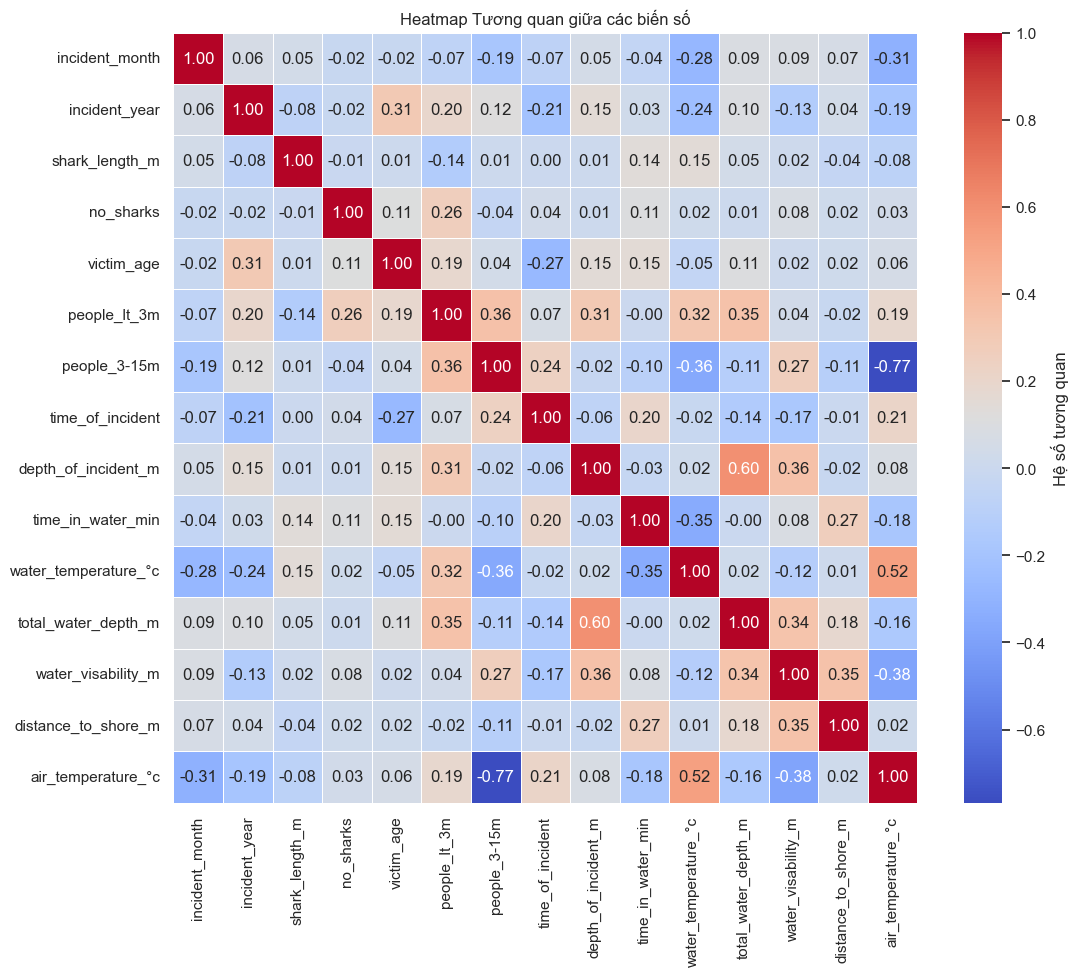

In [226]:
# loại biến hầu hết là -1
valid_num_cols = [c for c in num_cols if (df[c] != -1).sum() > 10]
corr_matrix = df[valid_num_cols].replace(-1, np.nan).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Hệ số tương quan'}
)
plt.title('Heatmap Tương quan giữa các biến số')
plt.show()

#### Nhận xét:

Các Mối Tương Quan Mạnh: $|r| \ge 0.5$)
- people_3-15m và air_temperature_°c (r = -0.77)
    - Tương quan âm rất mạnh (mối quan hệ mạnh nhất trong tập dữ liệu).
    - Khi nhiệt độ không khí tăng cao, số lượng người ở khu vực gần bờ (3–15 mét) lại có xu hướng giảm xuống. Điều này đi ngược lại trực giác thông thường (trời nóng thì đông người xuống biển hơn). 
    - Giải thích: khi trời quá nóng, người tắm biển có xu hướng bơi ra các vùng nước sâu hơn (xa bờ hơn 15 mét) để tìm kiếm nước mát hơn hoặc không gian rộng hơn, làm giảm mật độ ở khu vực gần bờ.
- total_water_depth_m và depth_of_incident_m (r = 0.60)
    - Tổng độ sâu của khu vực có liên quan chặt chẽ đến độ sâu nơi sự cố cá mập xảy ra.
    - Đây là mối quan hệ vật lý hợp lý, xác nhận tính nhất quán về dữ liệu địa lý, nơi tổng thể nước sâu thì sự cố có xu hướng xảy ra ở độ sâu lớn hơn.
- air_temperature_°c vs. water_temperature_°c (r = 0.52)
    - Nhiệt độ không khí cao có mối quan hệ trực tiếp với nhiệt độ nước.
    - Mối quan hệ môi trường này cho thấy các sự cố cá mập (và hoạt động của con người) thường tập trung vào các mùa có điều kiện nhiệt độ ấm áp.
Các Biến Tương Quan Yếu: Hầu hết các biến khác đều có tương quan yếu ($|r| < 0.2$), đặc biệt là các biến liên quan trực tiếp đến sinh vật học và độ sâu chính xác của sự cố như:
- shark_length_m: Tương quan gần bằng 0 với hầu hết các yếu tố môi trường và hành vi, kích thước của cá mập được ghi nhận không liên quan tuyến tính đến các biến khác.
- victim_age: Có tương quan yếu với tất cả các biến số khác, tuổi của nạn nhân không liên quan nhiều đến các yếu tố môi trường hay hành vi.
- no_sharks: Tương quan yếu, cho thấy phần lớn các sự cố được ghi nhận là các cuộc tấn công đơn lẻ, không liên quan trực tiếp đến số lượng cá mập được quan sát trong khu vực lân cận.

In [227]:
# Lưu dữ liệu đã xử lý
out_dir = "data/processed"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "SharkIncident_processed.csv")
df.to_csv(out_path, index=False)

## 2.6. Initial observations & insights

### 2.6.1. Key observations

- Nạn nhân & hành vi: Chủ yếu nam (~90%), trung bình 28 tuổi; hoạt động phổ biến dẫn đến sự cố: bơi lội và lướt ván.

- Mức độ nghiêm trọng: Tỷ lệ tử vong ~20%, bị thương ~60%.

- Loài & vị trí: White, Tiger, Bull shark; tập trung ven biển (65.8%), NSW/QLD/WA.

- Phát hiện khác: Nhiệt độ tăng → ít người ở vùng nước nông (r = -0.77).

### 2.6.2. Data quality issues

- Missing data: Thiếu nhiều ở time_in_water_min, distance_to_shore_m, total_water_depth_m; các biến chi tiết như clothing_pattern gần như trống.

- Định dạng & nhất quán: Cần ép kiểu số, chuẩn hóa text (lowercase, xóa khoảng trắng).

### 2.6.3. Preprocessing steps

- Loại bỏ cột tỷ lệ missing >99% hoặc không cần thiết.

- Điền khuyết: -1 (số), "unknown" (phân loại).

- Làm sạch: xử lý giá trị âm/0 vô lý.

- Chuẩn hóa text.

### 2.6.4. Limitations

Missing data & outliers: Thiếu dữ liệu nhiều cột là các text mô tả chi tiết; một số outlier đặc biệt phản ánh tình huống cá biệt.

Biases: có thể bị bias do thiên kiến của báo cáo lịch sử, nhân chứng phóng đại kích thước, nhiều loài chưa xác định, .v.v

# 3. QUESTION FORMULATION

## 3.1. Xu hướng phân bố các vụ tấn công cá mập tại Úc thay đổi như thế nào theo thời gian và không gian?

a. Mục đích: xác định xem sự gia tăng các vụ tấn công là do sự mở rộng hoạt động của con người sang các vùng biển mới hay do thay đổi hành vi của cá mập theo mùa

b. Lợi ích:
- Cung cấp cái nhìn tổng quan để dự báo các khu vực rủi ro cao trong tương lai
- Hỗ trợ phân bổ nguồn lực cứu hộ và đưa ra cảnh báo du lịch chính xác hơn theo từng vùng và thời điểm trong năm.

c. Những người sẽ quan tâm: chính quyền địa phương, các cơ quan quản lý du lịch và an toàn biển, người đi biển, v.v.

## 3.2. Có mối liên hệ nào giữa loài cá mập và mức độ nghiêm trọng của chấn thương không?

a. Mục đích: xác định mức độ nguy hiểm thực tế của từng loài

b. Lợi ích:
- Giúp phân loại rủi ro dựa trên loài cá mập được phát hiện tại khu vực
- Cung cấp thông tin để chuẩn bị phương án sơ cấp cứu phù hợp

c. Những đối tượng sẽ quan tâm: các nhà sinh vật học biển, nhân viên y tế cấp cứu, công chúng, v.v.

## 3.3. Độ sâu tại vị trí xảy ra sự cố ảnh hưởng như thế nào kiểu hành vi tấn công của cá mập?

a. Mục đích: hiểu rõ chiến thuật săn mồi của cá mập trong các môi trường độ sâu khác nhau

b. Lợi ích:
- Giúp người dân nhận biết rủi ro tiềm ẩn khi hoạt động ở các độ sâu khác nhau
- Đưa ra khuyến cáo an toàn cụ thể cho người bơi, thợ lặn

c. Những đối tượng sẽ quan tâm: thợ lặn, người lướt sóng, các nhà nghiên cứu hành vi động vật, v.v.

## 3.4. Số lượng cá mập tham gia có ảnh hưởng đến đối tượng bị cắn hoặc mức độ nghiêm trọng không?

a. Mục đích: hiểu rõ hơn về động cơ của các cuộc tấn công hiếm gặp liên quan đến nhiều cá mập

b. Lợi ích:
- Cải thiện thiết kế thiết bị để giảm thiểu sự thu hút đối với các nhóm cá mập
- Cảnh báo người dân về những vật dụng sử dụng khi xuống biển để giảm rủi ro

c. Những đối tượng sẽ quan tâm: các nhà sản xuất thiết bị bảo hộ, người lướt ván, người bơi, v.v.

## 3.5. Giới tính của nạn nhân và tính chất của vụ tấn công có mối liên hệ như thế nào?

a. Mục đích: xác định xem yếu tố rủi ro đến từ hành vi chủ động khiêu khích của con người hay do ngẫu nhiên, và liệu có sự khác biệt về giới trong hành vi này

b. Lợi ích:
- Định hướng đối tượng cho các chương trình tuyên truyền ý thức an toàn, đảm bảo an toàn biển
- Giảm thiểu các vụ tấn công do sự khiêu khích của con người

c. Những đối tượng sẽ quan tâm: các cơ quan tuyên truyền, các nhà tâm lý học hành vi, v.v.

## 3.6 Liệu độ tuổi và giới tính của nạn nhân có ảnh hưởng đến khả năng bị tấn công bởi các loài cá mập cụ thể không?

a. Mục đích: tìm hiểu xem liệu các loài cá mập khác nhau có xu hướng "chọn" mục tiêu dựa trên kích thước (liên quan đến tuổi) hoặc hành vi đặc thù của nhóm nhân khẩu học hay không

b. Lợi ích: 
- Phát hiện các nhóm đối tượng dễ bị tổn thương nhất
- Đưa ra các cảnh báo cụ thể cho các nhóm nhân khẩu tại các vùng biển có loài cá mập đặc thù

c. Những đối tượng sẽ quan tâm: các cơ quan an toàn biển, nhà nghiên cứu, ngành du lịch biển, người đi biển, v.v.

## 3.7 Có thể phân nhóm các vụ tấn công thành các mẫu hình (patterns) riêng biệt dựa trên sự kết hợp của nhiều yếu tố (như vị trí, độ sâu, hoạt động, loài cá mập, ...) không?

a. Mục đích: tìm thấy pattern xuất hiện vụ tấn công 

b. Lợi ích
- Phát hiện ra các xu hướng tấn công điển hình (ví dụ: Nhóm "Tấn công vùng nước sâu - Cá mập trắng - Thợ lặn")
- Xây dựng các chiến lược phòng ngừa rủi ro toàn diện và hiệu quả hơn dựa trên các kịch bản tấn công thực tế

c. Những đối tượng sẽ quan tâm: các nhà khoa học dữ liệu, cơ quan an toàn biển, người đi biển, công chúng, v.v.

# 4. DATA ANALYSIS

## 4.6 Liệu đặc điểm nhân khẩu học của nạn nhân có ảnh hưởng đến tính chất sự cố (tính chủ động/bị động, loài cá tấn công) không?

In [232]:
from scipy.stats import chi2_contingency, f_oneway

top_sharks = ['white shark', 'tiger shark', 'bull shark', 'wobbegong']
df_main = df[df['shark_common_name'].isin(top_sharks)].copy()

cols_to_fix = ['victim_age', 'shark_length_m']
for col in cols_to_fix:
    df[col] = pd.to_numeric(df[col], errors='coerce') # Chuyển về số trước
    df[col] = df[col].replace(-1, np.nan) # Thay -1 thành NaN
    df[col] = df[col].replace(0, np.nan)  # Thay 0 thành NaN (nếu có, vì tuổi/chiều dài ko thể = 0)

# 2. Lọc dữ liệu cho phân tích
top_sharks = ['white shark', 'tiger shark', 'bull shark', 'wobbegong']
df_main = df[df['shark_common_name'].isin(top_sharks)].copy()

# Chuẩn hóa cột chữ
df_main['victim_gender'] = df_main['victim_gender'].str.lower().str.strip()
df_main['provoked_unprovoked'] = df_main['provoked_unprovoked'].str.lower().str.strip()

# 3. Loại bỏ dòng thiếu dữ liệu sau khi đã thay -1
# Chỉ giữ lại các dòng có đủ thông tin: Tuổi, Giới tính, Loại tấn công
df_main = df_main.dropna(subset=['victim_age', 'victim_gender', 'provoked_unprovoked'])

# Lọc chỉ lấy Male/Female và Provoked/Unprovoked (bỏ các giá trị lạ)
df_main = df_main[df_main['victim_gender'].isin(['male', 'female'])]
df_main = df_main[df_main['provoked_unprovoked'].isin(['provoked', 'unprovoked'])]


### 4.6.1. Thống kê nạn nhân theo độ tuổi và giới tính

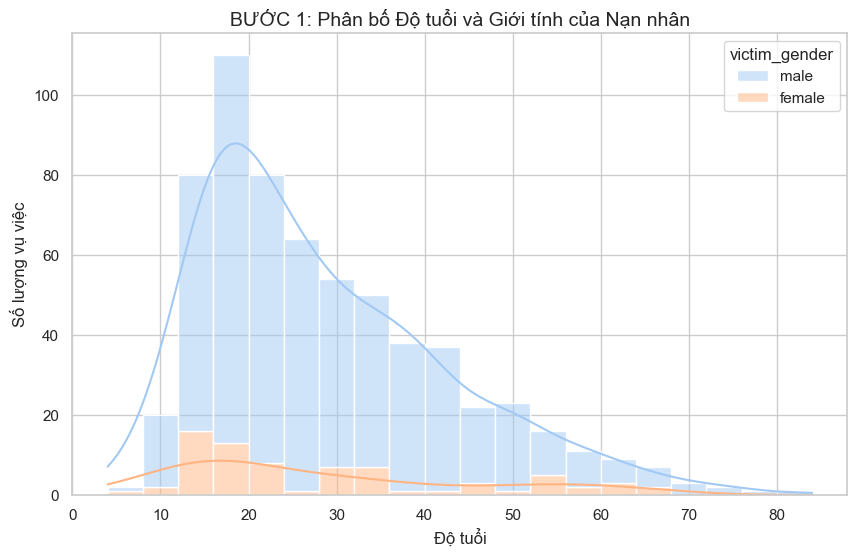

In [ ]:
plt.figure(figsize=(10, 6))

# vẽ histogram + đường mật độ (KDE)
sns.histplot(data=df_main, x='victim_age', hue='victim_gender', 
             multiple='stack', kde=True, palette='pastel', bins=20)

plt.title('BƯỚC 1: Phân bố Độ tuổi và Giới tính của Nạn nhân', fontsize=14)
plt.xlabel('Độ tuổi')
plt.ylabel('Số lượng vụ việc')
plt.show()

Từ biểu đồ ta thấy:
- Số lượng nạn nhân nam giới nhiều hơn rõ rệt so với nữ giới
- Độ tuổi nạn nhân tập trung nhiều nhất trong khoảng 15-25 tuổi, phân bố lệch phải, số lượng nạn nhân giảm dần khi độ tuổi tăng lên

Nam giới dường như có tần suất bị tấn công cao hơn nhiều so với nữ giới. Độ tuổi 15-30 có số vụ tấn công nhiều hơn hẳn. Liệu sự chênh lệch này là ngẫu nhiên hay do có sự khác biệt trong hành vi theo giới tính và độ tuổi?

### 4.6.2. Tính chất hành vi theo độ tuổi và giới tính

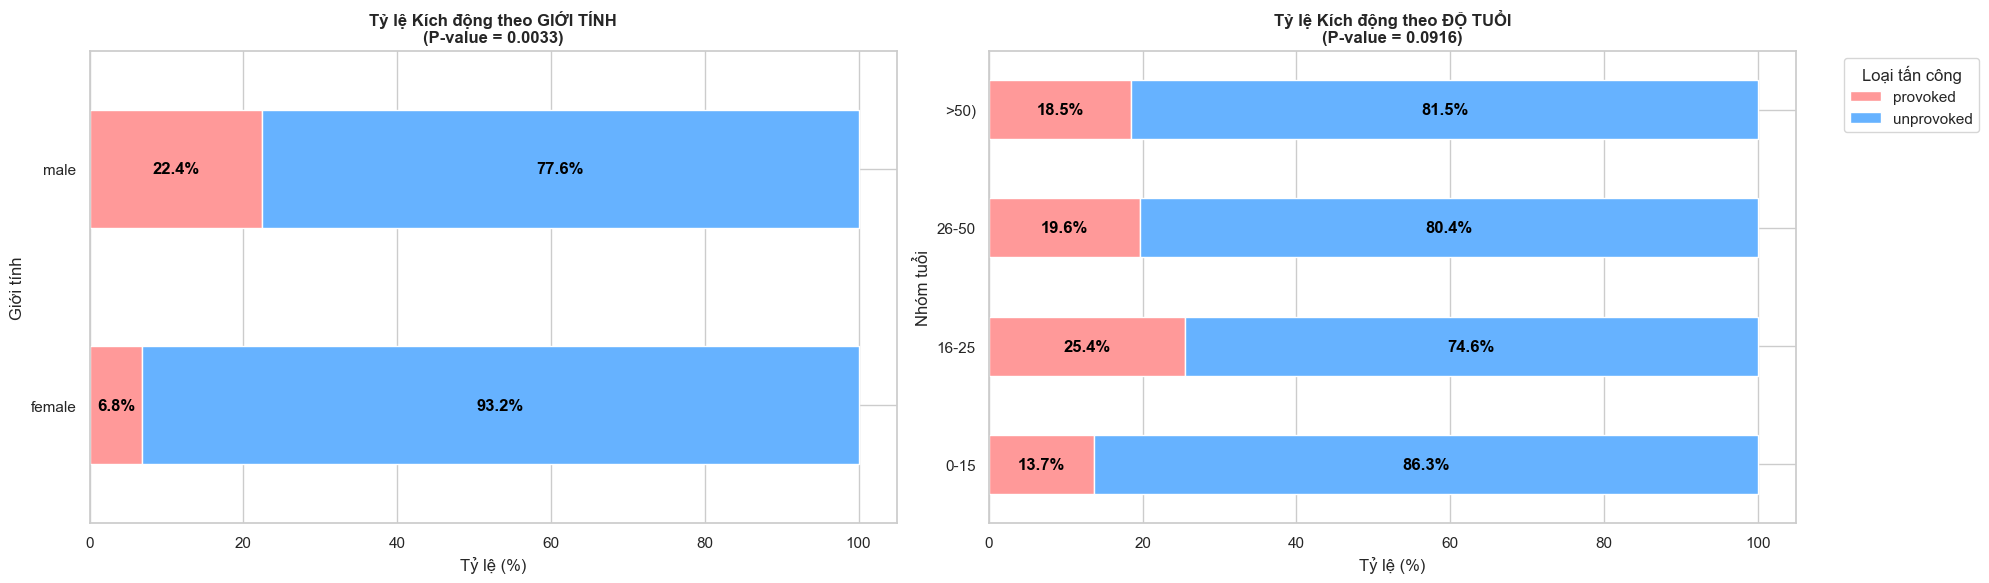

In [ ]:
df_viz = df_main.dropna(subset=['victim_age', 'victim_gender', 'provoked_unprovoked']).copy()
bins = [0, 15, 25, 50, 100]
labels = ['0-15', '16-25', '26-50', '>50']
df_viz['age_group'] = pd.cut(df_viz['victim_age'], bins=bins, labels=labels)

# A. Giới tính
ct_gender = pd.crosstab(df_viz['victim_gender'], df_viz['provoked_unprovoked'])
c_g, p_gender, _, _ = chi2_contingency(ct_gender)
ct_gender_pct = ct_gender.div(ct_gender.sum(1), axis=0) * 100

# B. Độ tuổi
ct_age = pd.crosstab(df_viz['age_group'], df_viz['provoked_unprovoked'])
c_a, p_age, _, _ = chi2_contingency(ct_age)
ct_age_pct = ct_age.div(ct_age.sum(1), axis=0) * 100

# --- BƯỚC 3: VẼ BIỂU ĐỒ (SIDE-BY-SIDE) ---
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
colors = ['#ff9999', '#66b2ff'] 

# >>> BIỂU ĐỒ 1: THEO GIỚI TÍNH
ct_gender_pct.plot(kind='barh', stacked=True, color=colors, ax=axes[0], edgecolor='white')
axes[0].set_title(f'Tỷ lệ Kích động theo GIỚI TÍNH\n(P-value = {p_gender:.4f})', fontweight='bold')
axes[0].set_xlabel('Tỷ lệ (%)')
axes[0].set_ylabel('Giới tính')
axes[0].legend().remove() # Tắt legend ở hình 1 cho đỡ rối

# >>> BIỂU ĐỒ 2: THEO ĐỘ TUỔI
ct_age_pct.plot(kind='barh', stacked=True, color=colors, ax=axes[1], edgecolor='white')
axes[1].set_title(f'Tỷ lệ Kích động theo ĐỘ TUỔI\n(P-value = {p_age:.4f})', fontweight='bold')
axes[1].set_xlabel('Tỷ lệ (%)')
axes[1].set_ylabel('Nhóm tuổi')
axes[1].legend(title='Loại tấn công', bbox_to_anchor=(1.05, 1), loc='upper left')

# >>> THÊM NHÃN SỐ LIỆU (%) VÀO GIỮA CỘT
for ax in axes:
    for c in ax.containers:
        # Chỉ hiện nhãn nếu thanh đủ lớn (>5%) để tránh chồng chữ
        labels = [f'{v.get_width():.1f}%' if v.get_width() > 5 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', color='black', weight='bold')

plt.tight_layout()
plt.show()

Biểu đồ cho thấy:
- Các vụ tấn công không do kích động chiếm đa số ở cả hai giới và mọi nhóm tuổi
- Tỷ lệ các vụ tấn công do kích động ở nam giới cao hơn đáng kể so với nữ giới (22,4% so với 6,8%), và sự khác biệt này có ý nghĩa thống kê (p = 0.0033), cho thấy giới tính có mối liên hệ với tính chất của sự cố
- Các nhóm tuổi cũng có sự chênh lệch, tuy nhiên chưa đủ bằng chứng để khẳng định ý nghĩa thống kê (p = 0,0916)

Nam giới dường như có xu hướng tham gia các hành vi mạo hiểm/tương tác trực tiếp với cá mập, làm tăng % các tình huống tấn công do kích động

### 4.6.3. Loài cá mập tấn công 

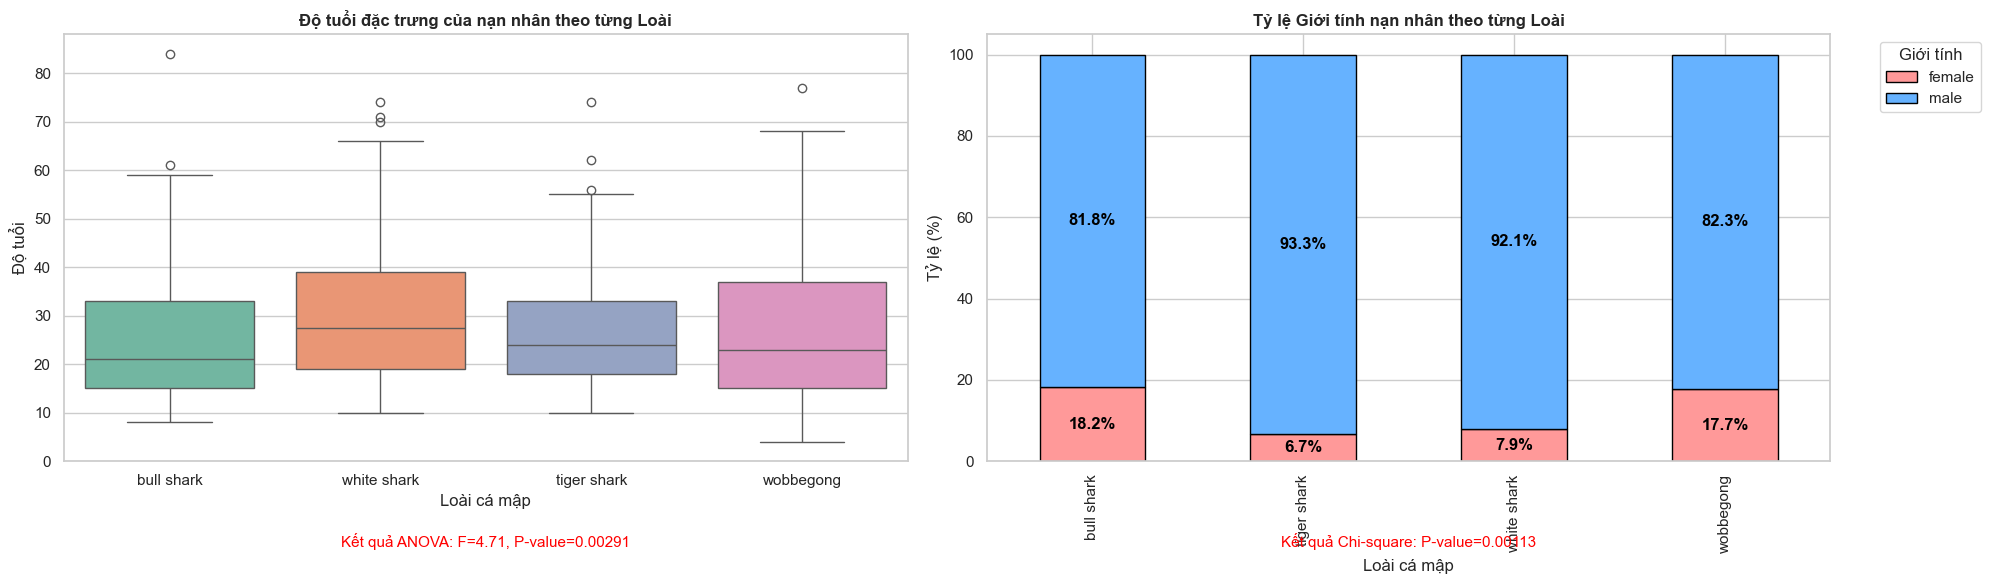

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency

# --- BƯỚC 1: CHUẨN BỊ DỮ LIỆU ---
# Đảm bảo df_main đã được lọc các loài chính (top_sharks) và có cột 'victim_age' dạng số
# Nếu chưa có, bạn chạy đoạn này:
# df['victim_age'] = pd.to_numeric(df['victim_age'], errors='coerce')
# top_sharks = ['white shark', 'tiger shark', 'bull shark', 'wobbegong']
# df_main = df[df['shark_common_name'].isin(top_sharks)].copy()
# df_main = df_main.dropna(subset=['victim_age', 'victim_gender'])

# --- BƯỚC 2: VẼ BIỂU ĐỒ SIDE-BY-SIDE ---
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# >>> HÌNH 1: LOÀI vs ĐỘ TUỔI (Boxplot)
sns.boxplot(x='shark_common_name', y='victim_age', data=df_main, palette='Set2', ax=axes[0])
axes[0].set_title('Phân bố độ tuổi nạn nhân của các loài', fontweight='bold')
axes[0].set_ylabel('Độ tuổi')
axes[0].set_xlabel('Loài cá mập')

# Kiểm định ANOVA cho Hình 1
groups = [df_main[df_main['shark_common_name'] == s]['victim_age'] for s in top_sharks]
f_stat, p_val = f_oneway(*groups)
axes[0].text(0.5, -0.2, f'Kết quả ANOVA: F={f_stat:.2f}, P-value={p_val:.5f}', 
            ha='center', fontsize=11, color='red', transform=axes[0].transAxes)

# >>> HÌNH 2: LOÀI vs GIỚI TÍNH (Stacked Bar Chart)
# Tạo bảng chéo và tính %
ct = pd.crosstab(df_main['shark_common_name'], df_main['victim_gender'])
ct_pct = ct.div(ct.sum(1), axis=0) * 100

# Kiểm định Chi-square cho Hình 2
chi2, p_chi2, _, _ = chi2_contingency(ct)

# Vẽ
ct_pct.plot(kind='bar', stacked=True, color=['#ff9999', '#66b2ff'], ax=axes[1], edgecolor='black')
axes[1].set_title('Tỷ lệ giới tính nạn nhân của các loài', fontweight='bold')
axes[1].set_ylabel('Tỷ lệ (%)')
axes[1].set_xlabel('Loài cá mập')
axes[1].legend(title='Giới tính', bbox_to_anchor=(1.05, 1))

# Thêm kết quả Chi-square dưới hình
axes[1].text(0.5, -0.2, f'Kết quả Chi-square: P-value={p_chi2:.5f}', 
            ha='center', fontsize=11, color='red', transform=axes[1].transAxes)

# Gắn nhãn số liệu % lên cột
for c in axes[1].containers:
    # Chỉ hiện số nếu thanh đủ lớn (>5%)
    labels = [f'{v.get_height():.1f}%' if v.get_height() > 5 else '' for v in c]
    axes[1].bar_label(c, labels=labels, label_type='center', color='black', weight='bold')

plt.tight_layout()
plt.show()

Từ biểu đồ ta thấy:
- Độ tuổi nạn nhân chủ yếu tập trung trong khoảng 15–40 tuổi
- White shark có độ tuổi trung vị cao nhất, trong khi bull shark có trung vị thấp nhất
- Một số giá trị ngoại lai xuất hiện ở các loài cho thấy vẫn có những trường hợp nạn nhân ở độ tuổi cao bất thường
- Nam giới chiếm đa số trong các vụ việc ở tất cả các loài cá mập
- Kiểm định ANOVA cho thấy các loài cá mập liên quan đến nạn nhân ở độ tuổi khác nhau (p < 0,05)
- Kiểm định Chi-square cho thấy giới tính của nạn nhân không khác biệt đáng kể giữa các loài (p > 0,05)

Kết quả cho thấy độ tuổi phản ánh rõ sự khác biệt trong hành vi tiếp xúc với từng loài cá mập, trong khi giới tính nạn nhân nhìn chung không thay đổi đáng kể theo loài

### 4.6.4. Kết luận

Giới tính có ảnh hưởng đến tính chất chủ động/bị động của sự cố, trong khi độ tuổi lại có sự liên quan đến loài cá mập mà nạn nhân gặp phải trong sự cố. Điều này sở dĩ do bản chất hành vi của từng giới tính và độ tuổi khác nhau. Nên đưa 2 yếu tố nhân khẩu học này vào cân nhắc khi phân tích nguyên do của một vụ tấn công cụ thể cũng như đưa ra những cảnh báo/tuyên truyền phù hợp theo giới và độ tuổi. 

## 4.7 Có thể phân nhóm các vụ tấn công thành các mẫu hình (patterns) riêng biệt dựa trên sự kết hợp của nhiều yếu tố (như vị trí, độ sâu, hoạt động, loài cá mập, ...) không?


In [237]:
# import thư viện cần thiết
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

In [238]:
# load dữ liệu đã xử lý
df = pd.read_csv('data/processed/SharkIncident_processed.csv')

### 4.7.1. Trích xuất đặc trưng

In [239]:
# tạo đặc trưng mùa ('season')
def get_season(month):
    if month in [12, 1, 2]: return 'Summer'
    elif month in [3, 4, 5]: return 'Autumn'
    elif month in [6, 7, 8]: return 'Winter'
    else: return 'Spring'
df['season'] = df['incident_month'].apply(get_season)

In [240]:
# tạo đặc trưng nhóm cá mập (nhóm các loài cá mập ít phổ biến lại thành 'Other')
top_sharks = ['white shark', 'tiger shark', 'bull shark', 'wobbegong']
df['shark_group'] = df['shark_common_name'].apply(lambda x: x if x in top_sharks else 'Other')

In [241]:
# tạo đặc trưng nhóm các hoạt động (nhóm các hoạt động kém phổ biến lại thành 'Other')
top_activities = ['swimming', 'surfing', 'fishing', 'diving']
df['activity_group'] = df['victim_activity'].astype(str).apply(
    lambda x: next((act for act in top_activities if act in x.lower()), 'Other')
)

In [242]:
# tạo đặc trưng xác định mức độ nghiêm trọng (fatal/non-fatal)
df['is_fatal'] = df['victim_injury'].apply(lambda x: 1 if 'fatal' in str(x).lower() else 0)

In [243]:
# định dạng lại độ dài cá mập
df['shark_length_m'] = pd.to_numeric(df['shark_length_m'], errors='coerce')
df.loc[df['shark_length_m'] <= 0, 'shark_length_m'] = np.nan

### 4.7.2. Xác định trọng số cho các đặc trưng

In [ ]:
# tính trọng số cho các đặc trưng (dùng Random Forest) 
# ##### lấy câu tz làm thay vào đây r cho trọng số
features = ['shark_group', 'activity_group', 'season', 'shark_length_m']
numeric_features = ['shark_length_m']
categorical_features = ['shark_group', 'activity_group', 'season']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)
    ])

# Fit & Transform
X_scaled = preprocessor.fit_transform(df[features])

# RF Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, df['is_fatal'])
importances = rf.feature_importances_

# Tạo dữ liệu Weighted (Nhân hệ số 5)
weights = 1 + (importances * 5)
X_weighted = X_scaled * weights

-> Đã tạo xong dữ liệu Weighted.


### 4.7.3. Tìm số cụm (K)

In [245]:
# tính 2 chỉ số inertia và silhouette với từng K
inertia = []
sil_scores = []
K_range = range(2, 9)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_weighted)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_weighted, km.labels_))

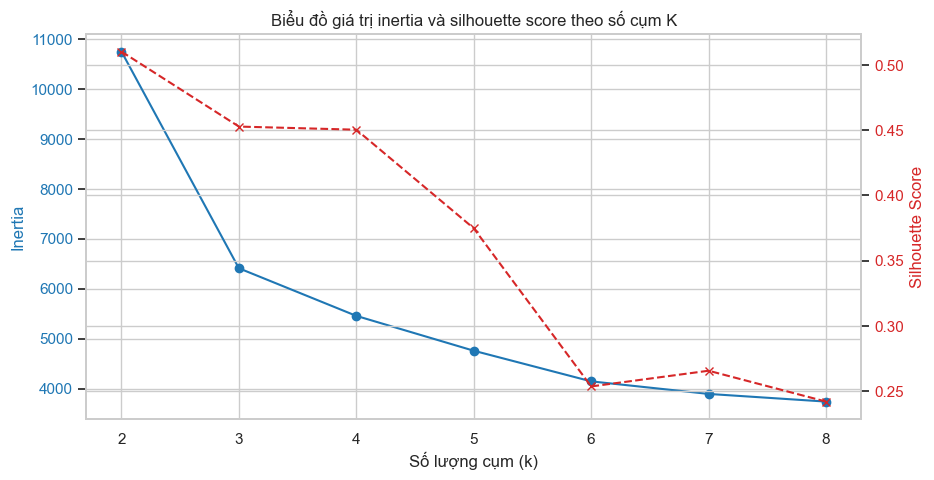

In [246]:
# vẽ biểu đồ giá trị 2 chỉ số với các K
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:blue'
ax1.set_xlabel('Số lượng cụm (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(K_range, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K_range, sil_scores, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Biểu đồ giá trị inertia và silhouette score theo số cụm K')
plt.show()

In [247]:
# chọn K=3 dựa trên biểu đồ
final_k = 3

### 3.7.4. Thực hiện gom cụm bằng 3 loại mô hình

In [248]:
# K-Means
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_weighted)

# Agglomerative (Gom cụm phân cấp)
agglo = AgglomerativeClustering(n_clusters=final_k, linkage='ward')
labels_agg = agglo.fit_predict(X_weighted)

# GMM (Gaussian Mixture)
gmm = GaussianMixture(n_components=final_k, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X_weighted)

In [249]:
# tính toán các chỉ số đánh giá
def get_metrics(X, labels):
    return (silhouette_score(X, labels), davies_bouldin_score(X, labels), calinski_harabasz_score(X, labels))

m_km = get_metrics(X_weighted, labels_km)
m_agg = get_metrics(X_weighted, labels_agg)
m_gmm = get_metrics(X_weighted, labels_gmm)

In [250]:
# in kết quả đánh giá 3 thuật toán
print(f"{'Metric':<25} | {'K-Means':<15} | {'Agglomerative':<15} | {'GMM':<15}")
print("-" * 80)
print(f"{'Silhouette (Max 1)':<25} | {m_km[0]:.4f}          | {m_agg[0]:.4f}          | {m_gmm[0]:.4f}")
print(f"{'Davies-Bouldin (Min 0)':<25} | {m_km[1]:.4f}          | {m_agg[1]:.4f}          | {m_gmm[1]:.4f}")
print(f"{'Calinski-Harabasz (Max)':<25} | {m_km[2]:.1f}          | {m_agg[2]:.1f}          | {m_gmm[2]:.1f}")


Metric                    | K-Means         | Agglomerative   | GMM            
--------------------------------------------------------------------------------
Silhouette (Max 1)        | 0.4527          | 0.4470          | 0.0528
Davies-Bouldin (Min 0)    | 0.8725          | 0.8848          | 3.9180
Calinski-Harabasz (Max)   | 1184.8          | 1174.0          | 93.9


### 3.7.5. Trực quan hoá kết quả

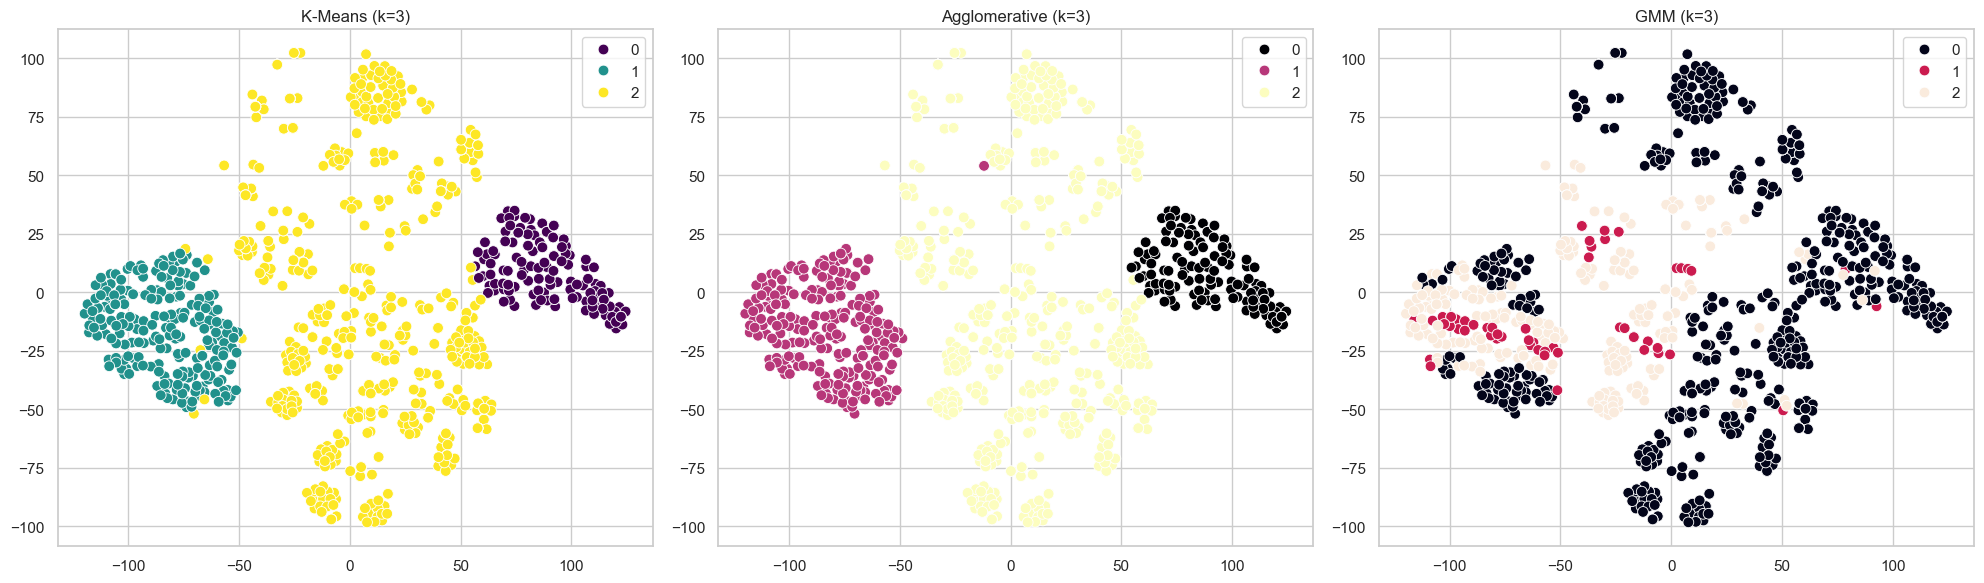

In [251]:
# trực quan hóa kết quả phân cụm với t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
X_tsne = tsne.fit_transform(X_weighted)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# K-Means
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_km, palette='viridis', ax=axes[0], s=60)
axes[0].set_title(f'K-Means (k={final_k})')
# Agglomerative
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_agg, palette='magma', ax=axes[1], s=60)
axes[1].set_title(f'Agglomerative (k={final_k})')
# GMM
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_gmm, palette='rocket', ax=axes[2], s=60)
axes[2].set_title(f'GMM (k={final_k})')
plt.tight_layout()
plt.show()

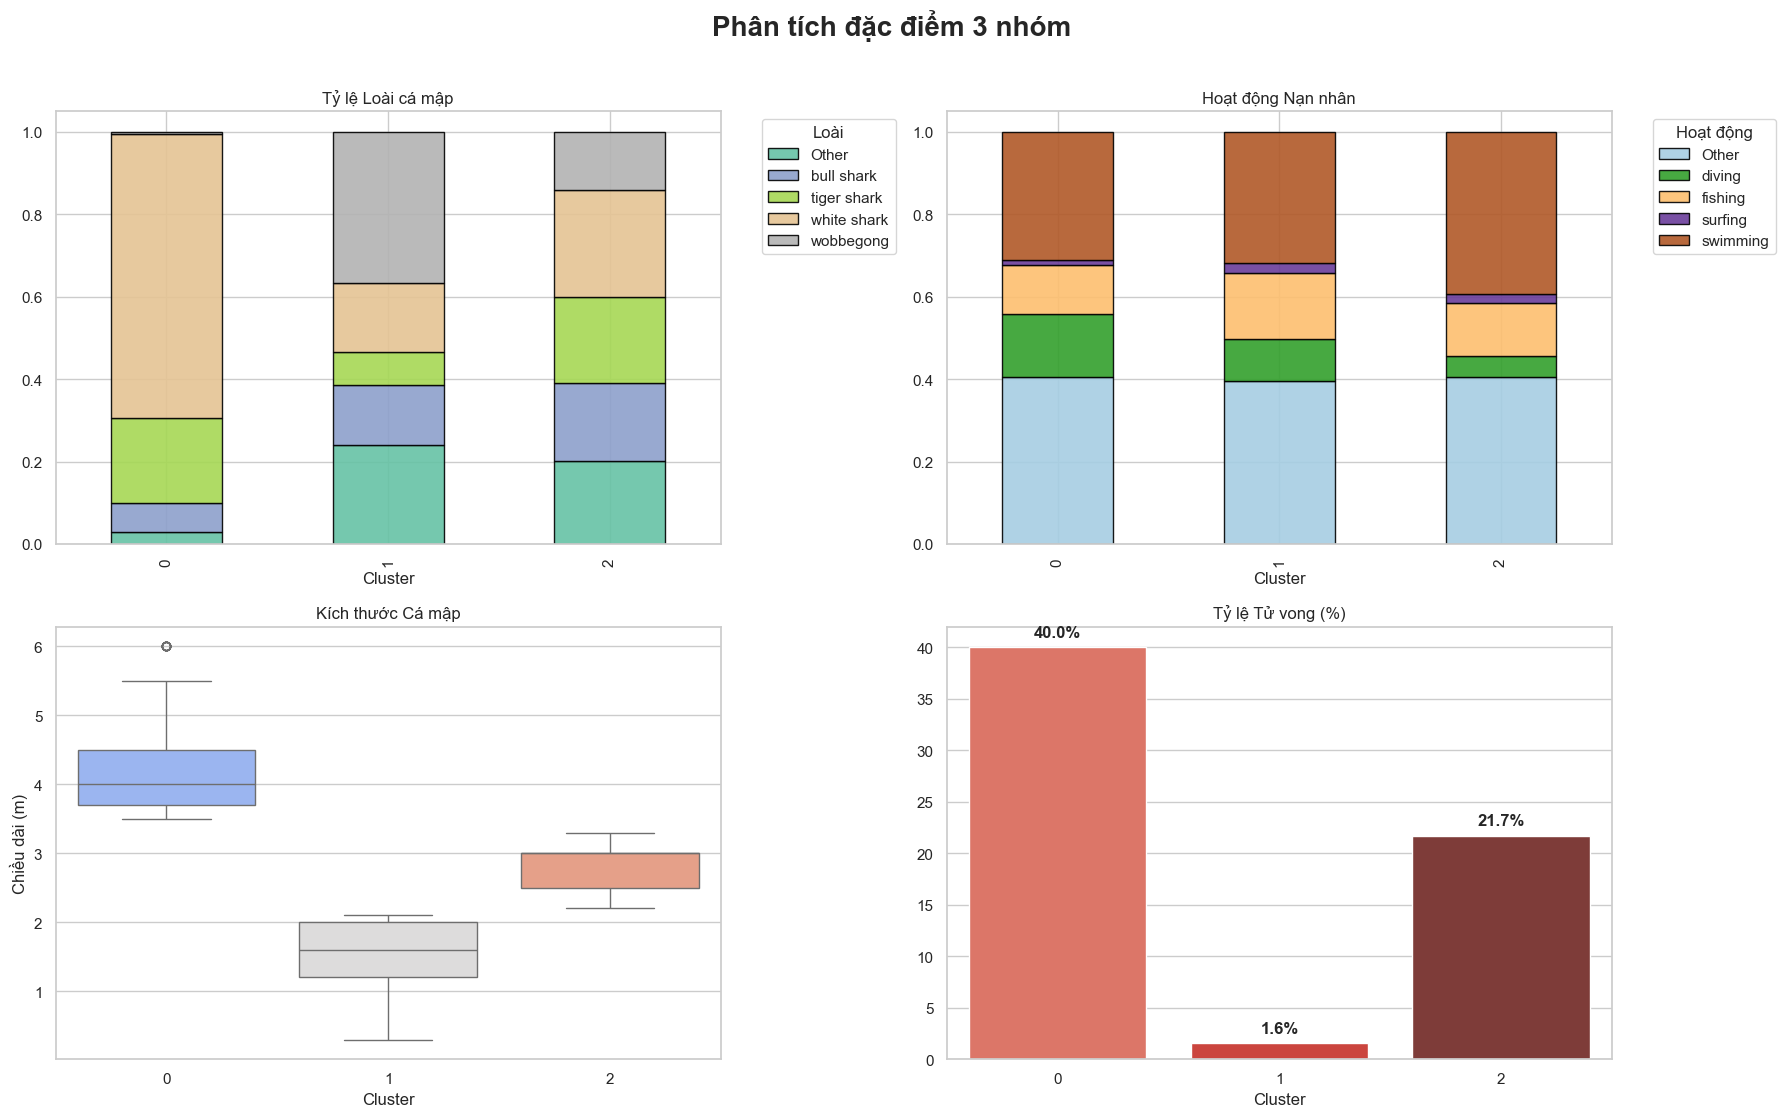

In [ ]:
# Gán nhãn K-Means vào DF
df['Cluster'] = labels_km

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.suptitle(f'Phân tích đặc điểm {final_k} nhóm', fontsize=20, fontweight='bold', y=0.96)

# loài (stacked bar)
pd.crosstab(df['Cluster'], df['shark_group'], normalize='index').plot(
    kind='bar', stacked=True, ax=axes[0, 0], colormap='Set2', edgecolor='black', alpha=0.9
)
axes[0, 0].set_title('Tỷ lệ Loài cá mập')
axes[0, 0].legend(title='Loài', bbox_to_anchor=(1.05, 1))

# hoạt động nạn nhân (stacked bar)
pd.crosstab(df['Cluster'], df['activity_group'], normalize='index').plot(
    kind='bar', stacked=True, ax=axes[0, 1], colormap='Paired', edgecolor='black', alpha=0.9
)
axes[0, 1].set_title('Hoạt động nạn nhân')
axes[0, 1].legend(title='Hoạt động', bbox_to_anchor=(1.05, 1))

# kích thước (boxplot)
sns.boxplot(x='Cluster', y='shark_length_m', data=df, ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Kích thước cá mập')
axes[1, 0].set_ylabel('Chiều dài (m)')

# tỷ lệ tử vong (bar)
fatal_rates = df.groupby('Cluster')['is_fatal'].mean() * 100
sns.barplot(x=fatal_rates.index, y=fatal_rates.values, ax=axes[1, 1], palette='Reds_d')
axes[1, 1].set_title('Tỷ lệ tử vong (%)')
for i, v in enumerate(fatal_rates):
    axes[1, 1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
summary = df.groupby('Cluster').agg({
    'shark_common_name': lambda x: x.mode()[0],
    'shark_length_m': 'mean',
    'is_fatal': 'mean',
    'season': lambda x: x.mode()[0]
}).reset_index()
summary['Tỷ lệ tử vong'] = (summary['is_fatal'] * 100).round(1).astype(str) + '%'
summary['Kích thước TB'] = summary['shark_length_m'].round(2)
summary.drop(columns=['is_fatal', 'shark_length_m'], inplace=True)

print(summary)

   Cluster shark_common_name  season Tỷ lệ Tử vong  Kích thước TB
0        0       white shark  Summer         40.0%           4.22
1        1         wobbegong  Summer          1.6%           1.53
2        2       white shark  Summer         21.7%           2.81


Từ hồ sơ phân cụm ta thấy có 3 nhóm:

Nhóm 1: rủi ro thấp
- Đa phần là các loài cá mập kích thước nhỏ (wobbegong và những loài khác)
- Tỷ lệ gây thương vong thấp (1.6%)
- Kích thước nhỏ (1.5-1.8m)
- Tính chất: các vụ tấn công này có thể là cá mập cắn do tự vệ khi vô tình tiếp xúc với con người, không nguy hiểm đến tính mạng

Nhóm 2: rủi ro vừa
- 

### 3.7.6. Nhận xét 

# 5. PROJECT SUMMARY

## 5.1. Key findings
## 5.2. Limitations
## 5.3. Future directions
## 5.4. Individual reflections

### 5.4.1. Thành viên 1
- Họ tên MSSV
- Challenges & Difficulties Encountered
- Learning & Growth